# <연구발표>
### [VGG16 net + Transfer Learning] + Adam & RMSprop
##### 무인이동체공학과 17011882 김 우 혁

##### Pytorch 공식 사이트의 Transfer Learning 튜토리얼 코드를 참고하였습니다.
출처 : https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html


#### Data Set Load

- 캐글에서 압축되어 있는 데이터셋을 다운 받아 구글 드라이브에 옮긴 뒤, 리눅스 명령어를 사용하여 압축을 풀었더니 일부 데이터가 손실되었습니다.

- 많은 시간이 소요되었지만 구글 드라이브에서 직접 데이터셋 압축을 푼 다음 이를 바로 사용하였습니다. 

In [ ]:
%cd /content/drive/MyDrive/Dataset/
!ls

/content/drive/MyDrive/Dataset
CAT_DOG      Covid19-dataset	  FOOD	    hymenoptera_data
CAT_DOG.zip  Covid19-dataset.zip  FOOD.zip  hymenoptera_data.zip


In [ ]:
from google.colab import drive # 내 구글 드라이브에 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # 대화형 모드

##### 내 드라이브에서 데이터 불러오기

- 데이터를 불러오기 위해 **torchvision**과 **torch.utils.data** 패키지를 사용



In [ ]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# 내가 사용할 데이터셋 폴더명으로 변경 후 사용!
data_dir = '/content/drive/MyDrive/Dataset/Covid19-dataset'

# torchvision.datasets.ImageFolder라는 메소드함수를 이용해서 DataLoader를 구축했습니다.
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# dataloader를 dictionary 형식으로 정의해서 train , validation으로 구분해주었습니다.
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val']}
# 내가 진행한 실험에서 'batch_size' 하이퍼 파라미터를 데이터셋의 크기에 비례하여 4, 16, 64로 변경 후 사용 
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

* dataset에 들어가는 원소는 tuple 형식 

* 하나는 이미지를 나타내는 [3 , 224 , 224]의 Tensor , 하나는 이미지의 클래스를 나타내는 Label  

In [ ]:
dataset_sizes # 훈련 데이터와 검증 데이터 크기 확인 -> 검증 데이터를 테스트 데이터로 활용!

{'train': 251, 'val': 66}

In [ ]:
class_names # 클래스 종류 확인

['Covid', 'Normal', 'Viral Pneumonia']

### 일부 이미지 시각화하기

데이터 증가를 이해하기 위해 일부 학습용 이미지를 시각화해보겠습니다.

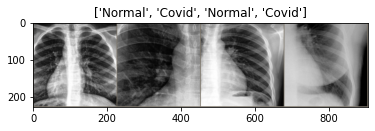

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 모델 학습

- 이제 모델을 학습하기 위한 일반 함수를 작성: 학습률(learning rate) 관리(scheduling) + 최적의 모델 구하기

- 아래에서 scheduler 매개변수는 torch.optim.lr_scheduler 의 LR 스케쥴러 객체(Object)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # 정확도 & 손실을 측정하기 위한 리스트 생성
    hist_loss = []
    hist_acc = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                ## model에 넣어줘야 하기 때문에 GPU로 보내줌
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적, 즉 train 상태일 때만 parameter 들을 update!!
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            # loss와 accuracy를 계산해줍니다.          
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'val': # 검증(테스트) 단계인 경우
                hist_loss.append(epoch_loss) # 위에서 생성한 리스트에 에포크당 손실 추가
                hist_acc.append(epoch_acc) # 위에서 생성한 리스트에 에포크당 정확도 추가

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    # 학습한 모델과 에포크당 손실, 정확도 리스트 반환
    return model, hist_loss, hist_acc

### 합성곱 신경망 미세조정(finetuning)

- 미리 학습한 모델을 불러온 후 마지막의 완전히 연결된 계층을 초기화
- 나의 데이터셋 클래스 수에 맞게 FC Layer를 추가하여 사용

##### Adam을 적용한 VGG16 모델 생성

In [ ]:
# 사용하려는 데이터 세트의 클래스 수
n_class=3
# pretrained 하이퍼파라미터를 True로 설정하여 전이학습 이용 
model_ft = models.vgg16_bn(pretrained=True)
# 나의 테이터셋 클래스 수에 맞게 FC Layer를 추가하여 사용
model_ft.classifier.add_module(module=nn.Linear(1000, n_class), name='7')

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Adam 옵티마이저 객체 생성
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

##### RMSprop을 적용한 VGG16 모델 생성

In [ ]:
# 사용하려는 데이터 세트의 클래스 수
n_class=3
# pretrained 하이퍼파라미터를 True로 설정하여 전이학습 이용 
model_ft2 = models.vgg16_bn(pretrained=True)
# 나의 테이터셋 클래스 수에 맞게 FC Layer를 추가하여 사용
model_ft2.classifier.add_module(module=nn.Linear(1000, n_class), name='7')

model_ft2 = model_ft2.to(device)

criterion = nn.CrossEntropyLoss()

# RMSprop 옵티마이저 객체 생성
optimizer_ft2 = optim.RMSprop(model_ft2.parameters(), lr=0.001)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler2 = lr_scheduler.StepLR(optimizer_ft2, step_size=7, gamma=0.1)

### 모델 학습 및 평가


In [ ]:
## VGG16 & Adam 모델 학습
# 손실 측정을 위한 리스트
result_loss = []
# 정확도 측정을 위한 리스트
result_acc = []

[model_ft, result_loss, result_acc] = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
## VGG16 & RMSprop 모델 학습
# 손실 측정을 위한 리스트
result_loss2 = []
# 정확도 측정을 위한 리스트
result_acc2 = []

[model_ft2, result_loss2, result_acc2] = train_model(model_ft2, criterion, optimizer_ft2, exp_lr_scheduler2,
                       num_epochs=25)

### 모델 성능 시각화

In [ ]:
## 손실 시각화
plt.plot([i for i in range(1, 26)], result_loss, "b--")
plt.plot([i for i in range(1, 26)], result_loss2, "r--")
plt.title('Covid19 - [Loss]')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Adam','RMSprop'])
plt.show()

## 정확도 시각화
plt.plot([i for i in range(1, 26)], result_acc, "b--")
plt.plot([i for i in range(1, 26)], result_acc2, "r--")
plt.title('Covid19 - [Accuracy]')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Adam','RMSprop'])
plt.show()

### 모델 저장

In [ ]:
torch.save(model_ft,'./model.pth')

In [ ]:
resnet=torch.load('./model.pth')

In [ ]:
visualize_model(resnet)